## Algoritmo de Clusterização Flower

### Tratamento dos dados

In [1]:
import numpy as np
import pandas as pd
import csv
import random
import time
import sqlite3
import difflib
import pm4py
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.objects.conversion.process_tree import converter
from pm4py.visualization.bpmn import visualizer as bpmn_visualization
from scipy import stats
from datetime import datetime

In [2]:
'''
#LOG BPI 2012 
from pm4py.objects.log.importer.xes import importer as xes_importer
#log_xes = pm4py.read_xes("BPI_Challenge_2012.xes")
log_xes = xes_importer.apply('BPI_Challenge_2012.xes')
df_pd = pm4py.convert_to_dataframe(log_xes)
df_pd


X_ = df_pd[['concept:name','case:concept:name', 'time:timestamp']]
log = pm4py.format_dataframe(X_, case_id='concept:name', activity_key='case:concept:name', timestamp_key='time:timestamp')
tree = pm4py.algo.discovery.inductive.variants.im.algorithm.apply_tree(log)
tree = pm4py.discover_process_tree_inductive(log)
bpmn_graph = pm4py.convert_to_bpmn(tree)
pm4py.view_bpmn(bpmn_graph)
'''

'\n#LOG BPI 2012 \nfrom pm4py.objects.log.importer.xes import importer as xes_importer\n#log_xes = pm4py.read_xes("BPI_Challenge_2012.xes")\nlog_xes = xes_importer.apply(\'BPI_Challenge_2012.xes\')\ndf_pd = pm4py.convert_to_dataframe(log_xes)\ndf_pd\n\n\nX_ = df_pd[[\'concept:name\',\'case:concept:name\', \'time:timestamp\']]\nlog = pm4py.format_dataframe(X_, case_id=\'concept:name\', activity_key=\'case:concept:name\', timestamp_key=\'time:timestamp\')\ntree = pm4py.algo.discovery.inductive.variants.im.algorithm.apply_tree(log)\ntree = pm4py.discover_process_tree_inductive(log)\nbpmn_graph = pm4py.convert_to_bpmn(tree)\npm4py.view_bpmn(bpmn_graph)\n'

## Pré-Processamento 

In [3]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log_xes = xes_importer.apply('dados_limpos_UTF8.xes')
#Carregando os dados da base
dados = sqlite3.connect('dados.db')
cursor = dados.cursor()
# Consulta teste realizada utilizando somente SQLite
#cursor.execute("SELECT identificação, situacao, destino, transicao FROM log WHERE assunto='REGIME ESPECIAL DE TRIBUTAÇÃO - ALIMENTOS E CONGÊNERES' AND ano='2018' ORDER BY datahoracadastro AND identificação")
#print(cursor.fetchall())
df = pd.read_sql_query("SELECT identificação, situacao, destino, datahoracadastro FROM log WHERE assunto='REGIME ESPECIAL DE TRIBUTAÇÃO - ALIMENTOS E CONGÊNERES' ORDER BY datahoracadastro AND identificação",dados)
print('Número de eventos: ', len(df))
print('Número de traces: ', len(df['identificação'].unique()))
df = df.rename(columns={'identificação':'caseId','datahoracadastro':'cadastro'}) 

#----------------------------------------------------------
# LIMPEZA: localiza pares de situações similares.
def all_similar_pairs(strings, cutoff=0.85):
    strings = strings.unique()
    result = []
    for i,s in enumerate(strings):
        r = difflib.get_close_matches(s, strings[i:], cutoff=cutoff)
        if len(r) > 1:
            result.append(r)
    result = [frozenset(s) for s in result]
    return result

print(all_similar_pairs(df.situacao, 0.7))

#----------------------------------------------------------
# Agrupamento das situações consideradas similares
df = df.replace({'situacao': {
    'REDISTRIBUÍDO': 'DISTRIBUÍDO',
    'REDIRECIONADO': 'DISTRIBUÍDO',
    'TRANSFERIDO': 'DISTRIBUÍDO',
    'ATO DECLARATÓRIO ASSINADO': 'DECLARAÇÃO ASSINADA',
    'CIENTE': 'CONTRIBUINTE CIENTE',
    'PROCESSO ANALISADO': 'ANALISADO'
    }})
print(np.sort(df.situacao.unique()))

#----------------------------------------------------------
# Inclui a coluna 'atividade' como a concatenação do destino com a situacao
df['atividade'] = df[['destino','situacao']].agg('-'.join, axis=1)

#----------------------------------------------------------
#Codificando atividades para valor inteiro (Utilizar somente para dados privados)
atv = df['atividade'].unique()
for i in range(df['atividade'].shape[0]):
    j = 0
    while(j<len(atv)):
        if(df['atividade'][i] == atv[j]):
            df['atividade'][i] = str(j)
            j = len(atv)
        else:
            j+=1

#----------------------------------------------------------
# REMOVER SEQUÊNCIAS DE ATIVIDADES IGUAIS DE UM MESMO CASE_ID. ATRIBIR ULTIMA DATAHORACADASTRO DA SEQUÊNCIA. 
duplicated = (df['situacao'] == df['situacao'].shift(1)) & (df['caseId'] == df['caseId'].shift(1))
first_id = 0
for id in df.index:
    if duplicated[id]:
        df.at[first_id,'cadastro'] = df.loc[id,'cadastro']
    else:
        first_id = id
df = df[~duplicated]

parsing log, completed traces ::   0%|          | 0/1391 [00:00<?, ?it/s]

Número de eventos:  34110
Número de traces:  1391
[frozenset({'DISTRIBUÍDO', 'REDISTRIBUÍDO'}), frozenset({'PARECER ASSINADO', 'DESPACHO ASSINADO'}), frozenset({'AGUARDANDO ASSINATURA DO CONSULTORIA', 'AGUARDANDO ASSINATURA DO ORIENTADOR', 'AGUARDANDO ASSINATURA DO COORDENADOR'}), frozenset({'AGUARDANDO ASSINATURA DO CONTRIBUINTE', 'AGUARDANDO CIÊNCIA DO CONTRIBUINTE', 'AGUARDANDO DOCUMENTO E/OU INFORMAÇÕES DO CONTRIBUINTE'}), frozenset({'ARQUIVADO', 'DESARQUIVADO'}), frozenset({'AGUARDANDO DOCUMENTO/INFORMAÇÃO', 'AGUARDANDO DOCUMENTO E/OU INFORMAÇÕES DO CONTRIBUINTE'}), frozenset({'AGUARDANDO ANÁLISE DO CONSULTORIA', 'AGUARDANDO ASSINATURA DO CONSULTORIA', 'AGUARDANDO ANÁLISE DO COORDENADOR'}), frozenset({'DECLARAÇÃO ASSINADA', 'ATO DE APROVAÇÃO ASSINADO', 'ATO DECLARATÓRIO ASSINADO'}), frozenset({'AGUARDANDO PROVIDÊNCIAS SEFAZ', 'AGUARDANDO PROVIDÊNCIAS', 'AGUARDANDO APROVAÇÃO'}), frozenset({'AGUARDANDO ASSINATURA DO CONSULTORIA', 'AGUARDANDO ASSINATURA DO COORDENADOR', 'AGUARDANDO A

## Funções do algoritmo 

In [4]:
import copy
import pkgutil

from pm4py.algo.discovery.dfg.utils.dfg_utils import get_activities_from_dfg, \
    infer_start_activities, infer_end_activities
from pm4py.algo.discovery.dfg.utils.dfg_utils import get_ingoing_edges, get_outgoing_edges
from pm4py.algo.discovery.dfg.utils.dfg_utils import negate, get_activities_self_loop, transform_dfg_to_directed_nx_graph
from pm4py.algo.discovery.dfg.variants import native as dfg_inst
from pm4py.algo.filtering.dfg.dfg_filtering import clean_dfg_based_on_noise_thresh
from pm4py.algo.discovery.inductive.variants.im.util import base_case, fall_through
from pm4py import util as pmutil
from pm4py.algo.discovery.inductive.variants.im.util import splitting as split
from pm4py.algo.discovery.inductive.util import parallel_cut_utils, detection_utils, cut_detection
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.statistics.end_activities.log import get as end_activities_get
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.util import exec_utils
from pm4py.objects.log.util import filtering_utils
import logging
from pm4py.util import constants
from enum import Enum
class Parameters(Enum):
    ACTIVITY_KEY = constants.PARAMETER_CONSTANT_ACTIVITY_KEY
    START_TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY
    TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_TIMESTAMP_KEY
    CASE_ID_KEY = constants.PARAMETER_CONSTANT_CASEID_KEY
    NOISE_THRESHOLD = "noiseThreshold"
    EMPTY_TRACE_KEY = "empty_trace"
    ONCE_PER_TRACE_KEY = "once_per_trace"
    CONCURRENT_KEY = "concurrent"
    STRICT_TAU_LOOP_KEY = "strict_tau_loop"
    TAU_LOOP_KEY = "tau_loop"

class SubtreePlain_W(object):
    def __init__(self, log, dfg, master_dfg, initial_dfg, activities, counts, rec_depth, noise_threshold=0,
                 start_activities=None, end_activities=None, initial_start_activities=None,
                 initial_end_activities=None, parameters=None, real_init=True):
        """
        Constructor

        Parameters
        -----------
        dfg
            Directly follows graph of this subtree
        master_dfg
            Original DFG
        initial_dfg
            Referral directly follows graph that should be taken in account adding hidden/loop transitions
        activities
            Activities of this subtree
        counts
            Shared variable
        rec_depth
            Current recursion depth
        """
        if real_init:
            self.master_dfg = copy.deepcopy(master_dfg)
            self.initial_dfg = copy.deepcopy(initial_dfg)
            self.counts = counts
            self.rec_depth = rec_depth
            self.noise_threshold = noise_threshold
            self.start_activities = start_activities
            if self.start_activities is None:
                self.start_activities = []
            self.end_activities = end_activities
            if self.end_activities is None:
                self.end_activities = []
            self.initial_start_activities = initial_start_activities
            if self.initial_start_activities is None:
                self.initial_start_activities = infer_start_activities(master_dfg)
            self.initial_end_activities = initial_end_activities
            if self.initial_end_activities is None:
                self.initial_end_activities = infer_end_activities(master_dfg)

            self.second_iteration = None
            self.activities = None
            self.dfg = None
            self.outgoing = None
            self.ingoing = None
            self.self_loop_activities = None
            self.initial_ingoing = None
            self.initial_outgoing = None
            self.activities_direction = None
            self.activities_dir_list = None
            self.negated_dfg = None
            self.negated_activities = None
            self.negated_outgoing = None
            self.negated_ingoing = None
            self.detected_cut = None
            self.children = None
            self.must_insert_skip = False
            self.log = log
            self.inverted_dfg = None
            self.original_log = log

            self.initialize_tree(dfg, log, initial_dfg, activities, parameters=parameters)

    def __deepcopy__(self, memodict={}):
        """
            def __init__(self, log, dfg, master_dfg, initial_dfg, activities, counts, rec_depth, noise_threshold=0,
                 start_activities=None, end_activities=None, initial_start_activities=None,
                 initial_end_activities=None, parameters=None, real_init=False):
        :param memodict:
        :return:
        """
        S = SubtreePlain_W(None, None, None, None, None, None, None, real_init=False)
        S.master_dfg = self.master_dfg
        S.initial_dfg = self.initial_dfg
        S.counts = self.counts
        S.rec_depth = self.rec_depth
        S.noise_threshold = self.noise_threshold
        S.start_activities = self.start_activities
        S.end_activities = self.end_activities
        S.initial_start_activities = self.initial_start_activities
        S.initial_end_activities = self.initial_end_activities
        S.second_iteration = self.second_iteration
        S.activities = self.activities
        S.dfg = self.dfg
        S.outgoing = self.outgoing
        S.ingoing = self.ingoing
        S.self_loop_activities = self.self_loop_activities
        S.initial_ingoing = self.initial_ingoing
        S.initial_outgoing = self.initial_outgoing
        S.activities_direction = self.activities_direction
        S.activities_dir_list = self.activities_dir_list
        S.negated_dfg = self.negated_dfg
        S.negated_activities = self.negated_activities
        S.negated_outgoing = self.negated_outgoing
        S.negated_ingoing = self.negated_ingoing
        S.detected_cut = self.detected_cut
        S.children = self.children
        S.must_insert_skip = self.must_insert_skip
        S.log = self.log
        S.inverted_dfg = self.inverted_dfg
        S.original_log = self.original_log
        try:
            S.parameters = self.parameters
        except:
            pass
        return S
    
    def initialize_tree(self, dfg, log, initial_dfg, activities, second_iteration=False, end_call=True,
                        parameters=None):
        """
            Initialize the tree


            Parameters
            -----------
            dfg
                Directly follows graph of this subtree
            log
                the event log
            initial_dfg
                Referral directly follows graph that should be taken in account adding hidden/loop transitions
            activities
                Activities of this subtree
            second_iteration
                Boolean that indicates if we are executing this method for the second time
            """

        self.second_iteration = second_iteration

        if activities is None:
            self.activities = get_activities_from_dfg(dfg)
        else:
            self.activities = copy.deepcopy(activities)

        if second_iteration:
            self.dfg = clean_dfg_based_on_noise_thresh(self.dfg, self.activities, self.noise_threshold)
        else:
            self.dfg = copy.deepcopy(dfg)

        self.initial_dfg = initial_dfg

        self.outgoing = get_outgoing_edges(self.dfg)
        self.ingoing = get_ingoing_edges(self.dfg)
        self.self_loop_activities = get_activities_self_loop(self.dfg)
        self.initial_outgoing = get_outgoing_edges(self.initial_dfg)
        self.initial_ingoing = get_ingoing_edges(self.initial_dfg)
        self.negated_dfg = negate(self.dfg)
        self.negated_activities = get_activities_from_dfg(self.negated_dfg)
        self.negated_outgoing = get_outgoing_edges(self.negated_dfg)
        self.negated_ingoing = get_ingoing_edges(self.negated_dfg)
        self.detected_cut = None
        self.children = []
        self.log = log
        self.original_log = log
        self.parameters = parameters

        self.detect_cut(second_iteration=False, parameters=parameters)
    
    def create_dfg(self, parameters=None):
        if parameters is None:
            parameters = {}

        dfg = [(k, v) for k, v in dfg_inst.apply(self.log, parameters=parameters).items() if v > 0]

        return dfg


    def is_followed_by(self, dfg, activity_a, activity_b):
        """
        check if Activity A is followed by Activity B in the dfg of self, returns bool.
        """
        for i in range(0, len(dfg)):
            if (activity_a, activity_b) == dfg[i][0]:
                return True

        return False


    def detect_xor(self, conn_components):
        """
        Detects xor cut
        Parameters
        --------------
        conn_components
            Connected components
        this_nx_graph
            NX graph calculated on the DFG
        strongly_connected_components
            Strongly connected components
        """
        if not self.contains_empty_trace() and len(conn_components) > 1:
            return [True, conn_components]

        return [False, []]


    def detect_concurrent(self):
        if self.contains_empty_trace():
            return [False, []]
        inverted_dfg = []  # create an inverted dfg, the connected components of this dfg are the split
        for a in self.activities:
            for b in self.activities:
                if a != b:
                    if not self.is_followed_by(self.dfg, a, b) or not self.is_followed_by(self.dfg, b, a):
                        if ((a, b), 1) not in inverted_dfg:
                            inverted_dfg.append(((a, b), 1))
                            inverted_dfg.append(((b, a), 1))
        self.inverted_dfg = inverted_dfg
        new_ingoing = get_ingoing_edges(inverted_dfg)
        new_outgoing = get_outgoing_edges(inverted_dfg)
        conn = detection_utils.get_connected_components(new_ingoing, new_outgoing, self.activities)
        if len(conn) > 1:
            conn = parallel_cut_utils.check_par_cut(conn, self.ingoing, self.outgoing)
            if len(conn) > 1:
                if parallel_cut_utils.check_sa_ea_for_each_branch(conn, self.start_activities, self.end_activities):
                    return [True, conn]

        return [False, []]


    def get_index_of_x_in_list(self, x, li):
        for i in range(0, len(li)):
            if li[i] == x:
                return i


    def find_set_with_x(self, x, list_of_sets):
        for i in range(0, len(list_of_sets)):
            if x in list_of_sets[i]:
                return i


    def contains_empty_trace(self):
        contains = False
        for trace in self.log:
            if len(trace) == 0:
                contains = True
        return contains


    def detect_loop(self):
        # p0 is part of return value, it contains the partition of activities
        # write all start and end activities in p1
        if self.contains_empty_trace():
            return [False, []]
        p1 = []
        for act in self.start_activities:
            if act not in p1:
                p1.append(act)
        for act in self.end_activities:
            if act not in p1:
                p1.append(act)

        # create new dfg without the transitions to start and end activities
        new_dfg = copy.deepcopy(self.dfg)
        copy_dfg = copy.deepcopy(new_dfg)
        for ele in copy_dfg:
            if ele[0][0] in p1 or ele[0][1] in p1:
                new_dfg.remove(ele)

        current_activities = {}
        iterate_order = []
        for element in self.activities:
            if element not in p1:
                current_activities.update({element: 1})
                iterate_order.append(element)
        # create an overview of what activity has which outgoing connections
        outgoing = [list() for _ in range(len(iterate_order))]
        for i in range(0, len(iterate_order)):
            current_act = iterate_order[i]
            for element in new_dfg:
                if element[0][0] == current_act:
                    if element[0][1] in iterate_order:
                        outgoing[i].append(element[0][1])

        # built p2, ..., pn :
        acts_not_assigned_to_set = copy.deepcopy(iterate_order)
        p = [list() for _ in range(len(iterate_order))]
        max_set = iterate_order
        max_set_found = False
        for i in range(0, len(iterate_order)):
            act = iterate_order[i]
            if act in acts_not_assigned_to_set:
                p[i] = [act]
                acts_not_assigned_to_set.remove(act)
                added = True
                while added:
                    added = False
                    # check if max set is already found
                    count = 0
                    for li in p:
                        if len(li) != 0:
                            count += 1
                    if count == len(max_set):
                        max_set_found = True
                        break
                    # if max set is not found, continue adding acts
                    for act_b in p[i]:
                        index_of_act_b_in_outgoing = self.get_index_of_x_in_list(act_b, iterate_order)
                        for outgoing_act in outgoing[index_of_act_b_in_outgoing]:
                            if outgoing_act in acts_not_assigned_to_set:
                                acts_not_assigned_to_set.remove(outgoing_act)
                                p[i].append(outgoing_act)
                                added = True
                                break
                        if added:
                            break
            if max_set_found:
                break

        for li in p:
            if len(li) == 0:
                p.remove(li)

        # p0 = get_connected_components(new_ingoing, new_outgoing, current_activities)
        p.insert(0, p1)
        p0 = p
        iterable_dfg = []
        for i in range(0, len(self.dfg)):
            iterable_dfg.append(self.dfg[i][0])
        # p0 is like P1,P2,...,Pn in line 3 on page 190 of the IM Thesis
        # check for subsets in p0 that have connections to and end or from a start activity
        p0_copy = []
        for int_el in p0:
            p0_copy.append(int_el)
        for element in p0_copy:  # for every set in p0
            removed = False
            if element in p0 and element != p0[0]:
                for act in element:  # for every activity in this set
                    for e in self.end_activities:  # for every end activity
                        if e not in self.start_activities:
                            if (act, e) in iterable_dfg:  # check if connected
                                # is there an element in dfg pointing from any act in a subset of p0 to an end activity
                                for activ in element:
                                    if activ not in p0[0]:
                                        p0[0].append(activ)
                                if element in p0:
                                    p0.remove(element)  # remove subsets that are connected to an end activity
                                removed = True
                                break
                    if removed:
                        break
                    for s in self.start_activities:
                        if s not in self.end_activities:
                            if not removed:
                                if (s, act) in iterable_dfg:
                                    for acti in element:
                                        if acti not in p0[0]:
                                            p0[0].append(acti)
                                    if element in p0:
                                        p0.remove(element)  # remove subsets that are connected to an end activity
                                    removed = True
                                    break
                            else:
                                break
                    if removed:
                        break

        iterable_dfg = list()
        for i in range(0, len(self.dfg)):
            iterable_dfg.append(self.dfg[i][0])

        p0_copy = []
        for int_el in p0:
            p0_copy.append(int_el)
        for element in p0:
            if element in p0 and element != p0[0]:
                for act in element:
                    for e in self.end_activities:
                        if (e, act) in iterable_dfg:  # get those act, that are connected from an end activity
                            for e2 in self.end_activities:  # check, if the act is connected from all end activities
                                if (e2, act) not in iterable_dfg:
                                    for acti in element:
                                        if acti not in p0[0]:
                                            p0[0].append(acti)
                                    if element in p0:
                                        p0.remove(element)  # remove subsets that are connected to an end activity
                                    break
                    for s in self.start_activities:
                        if (act, s) in iterable_dfg:  # same as above (in this case for activities connected to
                            # a start activity)
                            for s2 in self.start_activities:
                                if (act, s2) not in iterable_dfg:
                                    for acti in element:
                                        if acti not in p0[0]:
                                            p0[0].append(acti)
                                    if element in p0:
                                        p0.remove(element)  # remove subsets that are connected to an end activity
                                    break
        index_to_delete = []
        for i in range(0, len(p0)):
            if not p0[i]:
                index_to_delete.insert(0, i)
        for index in index_to_delete:
            p0.remove(p0[index])
        if len(p0) > 1:
            return [True, p0]
        else:
            return [False, []]


    def check_for_cut(self, test_log, deleted_activity=None, parameters=None):
        if pkgutil.find_loader("networkx"):
            import networkx as nx

            if deleted_activity is not None:
                del self.activities[deleted_activity]
            if parameters is None:
                parameters = {}
            dfg = [(k, v) for k, v in dfg_inst.apply(test_log, parameters=parameters).items() if v > 0]
            self.dfg = dfg
            self.outgoing = get_outgoing_edges(self.dfg)
            self.ingoing = get_ingoing_edges(self.dfg)
            self.log = test_log
            conn_components = detection_utils.get_connected_components(self.ingoing, self.outgoing, self.activities)
            this_nx_graph = transform_dfg_to_directed_nx_graph(self.dfg, activities=self.activities)
            strongly_connected_components = [list(x) for x in nx.strongly_connected_components(this_nx_graph)]
            # search for cut and return true as soon as a cut is found:
            xor_cut = self.detect_xor(conn_components)
            if xor_cut[0]:
                return True
            else:
                sequence_cut = cut_detection.detect_sequential_cut(self, self.dfg, strongly_connected_components)
                if sequence_cut[0]:
                    return True
                else:
                    parallel_cut = self.detect_concurrent()
                    if parallel_cut[0]:
                        return True
                    else:
                        loop_cut = self.detect_loop()
                        if loop_cut[0]:
                            return True
                        else:
                            return False
        else:
            msg = "networkx is not available. inductive miner cannot be used!"
            logging.error(msg)
            raise Exception(msg)


    def detect_cut(self, second_iteration=False, parameters=None):
        if pkgutil.find_loader("networkx"):
            import networkx as nx

            if parameters is None:
                parameters = {}
            activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters,
                                                      pmutil.xes_constants.DEFAULT_NAME_KEY)

            # check base cases:
            empty_log = base_case.empty_log(self.log)
            single_activity = base_case.single_activity(self.log, activity_key)
            if empty_log:
                self.detected_cut = 'empty_log'
            elif single_activity:
                self.detected_cut = 'single_activity'
            # if no base cases are found, search for a cut:
            else:
                conn_components = detection_utils.get_connected_components(self.ingoing, self.outgoing, self.activities)
                this_nx_graph = transform_dfg_to_directed_nx_graph(self.dfg, activities=self.activities)
                strongly_connected_components = [list(x) for x in nx.strongly_connected_components(this_nx_graph)]
                xor_cut = self.detect_xor(conn_components)
                # the following part searches for a cut in the current log
                # if a cut is found, the log is split according to the cut, the resulting logs are saved in new_logs
                # recursion is used on all the logs in new_logs
                if xor_cut[0]:
                    logging.debug("xor_cut")
                    self.detected_cut = 'concurrent'
                    new_logs = split.split_xor(xor_cut[1], self.log, activity_key)
                    for i in range(len(new_logs)):
                        new_logs[i] = filtering_utils.keep_one_trace_per_variant(new_logs[i], parameters=parameters)
                    for l in new_logs:
                        new_dfg = [(k, v) for k, v in dfg_inst.apply(l, parameters=parameters).items() if v > 0]
                        activities = attributes_get.get_attribute_values(l, activity_key)
                        start_activities = list(
                            start_activities_get.get_start_activities(l, parameters=parameters).keys())
                        end_activities = list(
                            end_activities_get.get_end_activities(l, parameters=parameters).keys())
                        self.children.append(
                            SubtreePlain_W(l, new_dfg, self.master_dfg, self.initial_dfg, activities, self.counts,
                                         self.rec_depth + 1,
                                         noise_threshold=self.noise_threshold, start_activities=start_activities,
                                         end_activities=end_activities,
                                         initial_start_activities=self.initial_start_activities,
                                         initial_end_activities=self.initial_end_activities,
                                         parameters=parameters))
                else:
                    sequence_cut = cut_detection.detect_sequential_cut(self, self.dfg, strongly_connected_components)
                    if sequence_cut[0]:
                        logging.debug("sequence_cut")
                        new_logs = split.split_sequence(sequence_cut[1], self.log, activity_key)
                        for i in range(len(new_logs)):
                            new_logs[i] = filtering_utils.keep_one_trace_per_variant(new_logs[i],
                                                                                     parameters=parameters)
                        self.detected_cut = "sequential"
                        for l in new_logs:
                            new_dfg = [(k, v) for k, v in dfg_inst.apply(l, parameters=parameters).items() if v > 0]
                            activities = attributes_get.get_attribute_values(l, activity_key)
                            start_activities = list(
                                start_activities_get.get_start_activities(l, parameters=parameters).keys())
                            end_activities = list(
                                end_activities_get.get_end_activities(l, parameters=parameters).keys())
                            self.children.append(
                                SubtreePlain_W(l, new_dfg, self.master_dfg, self.initial_dfg, activities, self.counts,
                                             self.rec_depth + 1,
                                             noise_threshold=self.noise_threshold, start_activities=start_activities,
                                             end_activities=end_activities,
                                             initial_start_activities=self.initial_start_activities,
                                             initial_end_activities=self.initial_end_activities,
                                             parameters=parameters))
                    else:
                        parallel_cut = self.detect_concurrent()
                        if parallel_cut[0]:
                            logging.debug("parallel_cut")
                            new_logs = split.split_parallel(parallel_cut[1], self.log, activity_key)
                            for i in range(len(new_logs)):
                                new_logs[i] = filtering_utils.keep_one_trace_per_variant(new_logs[i],
                                                                                         parameters=parameters)
                            self.detected_cut = "parallel"
                            for l in new_logs:
                                new_dfg = [(k, v) for k, v in dfg_inst.apply(l, parameters=parameters).items() if v > 0]
                                activities = attributes_get.get_attribute_values(l, activity_key)
                                start_activities = list(
                                    start_activities_get.get_start_activities(l,
                                                                              parameters=parameters).keys())
                                end_activities = list(
                                    end_activities_get.get_end_activities(l, parameters=parameters).keys())
                                self.children.append(
                                    SubtreePlain_W(l, new_dfg, self.master_dfg, self.initial_dfg, activities, self.counts,
                                                 self.rec_depth + 1,
                                                 noise_threshold=self.noise_threshold,
                                                 start_activities=start_activities,
                                                 end_activities=end_activities,
                                                 initial_start_activities=self.initial_start_activities,
                                                 initial_end_activities=self.initial_end_activities,
                                                 parameters=parameters))
                        else:
                            loop_cut = self.detect_loop()
                            if loop_cut[0]:
                                logging.debug("loop_cut")
                                new_logs = split.split_loop(loop_cut[1], self.log, activity_key)
                                for i in range(len(new_logs)):
                                    new_logs[i] = filtering_utils.keep_one_trace_per_variant(new_logs[i],
                                                                                             parameters=parameters)
                                self.detected_cut = "loopCut"
                                for l in new_logs:
                                    new_dfg = [(k, v) for k, v in dfg_inst.apply(l, parameters=parameters).items() if
                                               v > 0]
                                    activities = attributes_get.get_attribute_values(l, activity_key)
                                    start_activities = list(
                                        start_activities_get.get_start_activities(l,
                                                                                  parameters=parameters).keys())
                                    end_activities = list(
                                        end_activities_get.get_end_activities(l,
                                                                              parameters=parameters).keys())
                                    self.children.append(
                                        SubtreePlain_W(l, new_dfg, self.master_dfg, self.initial_dfg, activities,
                                                     self.counts,
                                                     self.rec_depth + 1,
                                                     noise_threshold=self.noise_threshold,
                                                     start_activities=start_activities,
                                                     end_activities=end_activities,
                                                     initial_start_activities=self.initial_start_activities,
                                                     initial_end_activities=self.initial_end_activities,
                                                     parameters=parameters))

                            # if the code gets to this point, there is no base_case and no cut found in the log
                            # therefore, we now apply fall through:
                            else:
                                self.apply_fall_through(parameters)
        else:
            msg = "networkx is not available. inductive miner cannot be used!"
            logging.error(msg)
            raise Exception(msg)


    # this is called at the end of detect_cut, if no cut was found and a fallthrough needs to be applied
    def apply_fall_through(self, parameters=None):
        if parameters is None:
            parameters = {}
        activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters,
                                                  pmutil.xes_constants.DEFAULT_NAME_KEY)

        # set flags for fall_throughs, base case is True (enabled)
        use_empty_trace = (Parameters.EMPTY_TRACE_KEY not in parameters) or parameters[
            Parameters.EMPTY_TRACE_KEY]
        use_act_once_per_trace = (Parameters.ONCE_PER_TRACE_KEY not in parameters) or parameters[
            Parameters.ONCE_PER_TRACE_KEY]
        use_act_concurrent = (Parameters.CONCURRENT_KEY not in parameters) or parameters[
            Parameters.CONCURRENT_KEY]
        use_strict_tau_loop = (Parameters.STRICT_TAU_LOOP_KEY not in parameters) or parameters[
            Parameters.STRICT_TAU_LOOP_KEY]
        use_tau_loop = (Parameters.TAU_LOOP_KEY not in parameters) or parameters[Parameters.TAU_LOOP_KEY]

        if use_empty_trace:
            empty_trace, new_log = fall_through.empty_trace(self.log)
            # if an empty trace is found, the empty trace fallthrough applies
            #
        else:
            empty_trace = False
        if empty_trace:
            logging.debug("empty_trace")
            activites_left = []
            for trace in new_log:
                for act in trace:
                    if act[activity_key] not in activites_left:
                        activites_left.append(act[activity_key])
            self.detected_cut = 'empty_trace'
            new_dfg = [(k, v) for k, v in dfg_inst.apply(new_log, parameters=parameters).items() if v > 0]
            activities = attributes_get.get_attribute_values(new_log, activity_key)
            start_activities = list(
                start_activities_get.get_start_activities(new_log, parameters=self.parameters).keys())
            end_activities = list(end_activities_get.get_end_activities(new_log, parameters=self.parameters).keys())
            self.children.append(
                SubtreePlain_W(new_log, new_dfg, self.master_dfg, self.initial_dfg, activities, self.counts,
                             self.rec_depth + 1,
                             noise_threshold=self.noise_threshold,
                             start_activities=start_activities,
                             end_activities=end_activities,
                             initial_start_activities=self.initial_start_activities,
                             initial_end_activities=self.initial_end_activities,
                             parameters=parameters))
        else:
            if use_act_once_per_trace:
                activity_once, new_log, small_log = fall_through.act_once_per_trace(self.log, self.activities,
                                                                                    activity_key)
                small_log = filtering_utils.keep_one_trace_per_variant(small_log, parameters=parameters)
            else:
                activity_once = False
            if use_act_once_per_trace and activity_once:
                self.detected_cut = 'parallel'
                # create two new dfgs as we need them to append to self.children later
                new_dfg = [(k, v) for k, v in dfg_inst.apply(new_log, parameters=parameters).items() if
                           v > 0]
                activities = attributes_get.get_attribute_values(new_log, activity_key)
                small_dfg = [(k, v) for k, v in dfg_inst.apply(small_log, parameters=parameters).items() if
                             v > 0]
                small_activities = attributes_get.get_attribute_values(small_log, activity_key)
                self.children.append(
                    SubtreePlain_W(small_log, small_dfg, self.master_dfg, self.initial_dfg, small_activities,
                                 self.counts,
                                 self.rec_depth + 1,
                                 noise_threshold=self.noise_threshold,
                                 initial_start_activities=self.initial_start_activities,
                                 initial_end_activities=self.initial_end_activities,
                                 parameters=parameters))
                # continue with the recursion on the new log
                start_activities = list(
                    start_activities_get.get_start_activities(new_log, parameters=self.parameters).keys())
                end_activities = list(
                    end_activities_get.get_end_activities(new_log, parameters=self.parameters).keys())
                self.children.append(
                    SubtreePlain_W(new_log, new_dfg, self.master_dfg, self.initial_dfg, activities,
                                 self.counts,
                                 self.rec_depth + 1,
                                 noise_threshold=self.noise_threshold,
                                 start_activities=start_activities,
                                 end_activities=end_activities,
                                 initial_start_activities=self.initial_start_activities,
                                 initial_end_activities=self.initial_end_activities,
                                 parameters=parameters))

            else:
                if use_act_concurrent:
                    activity_concurrent, new_log, small_log, activity_left_out = fall_through.activity_concurrent(self,
                                                                                                                  self.log,
                                                                                                                  self.activities,
                                                                                                                  activity_key,
                                                                                                                  parameters=parameters)
                    small_log = filtering_utils.keep_one_trace_per_variant(small_log, parameters=parameters)
                else:
                    activity_concurrent = False
                if use_act_concurrent and activity_concurrent:
                    self.detected_cut = 'parallel'
                    # create two new dfgs on to append later
                    new_dfg = [(k, v) for k, v in dfg_inst.apply(new_log, parameters=parameters).items() if
                               v > 0]
                    activities = attributes_get.get_attribute_values(new_log, activity_key)
                    small_dfg = [(k, v) for k, v in dfg_inst.apply(small_log, parameters=parameters).items() if
                                 v > 0]
                    small_activities = attributes_get.get_attribute_values(small_log, activity_key)
                    # append the concurrent activity as leaf:
                    self.children.append(
                        SubtreePlain_W(small_log, small_dfg, self.master_dfg, self.initial_dfg,
                                     small_activities,
                                     self.counts,
                                     self.rec_depth + 1,
                                     noise_threshold=self.noise_threshold,
                                     initial_start_activities=self.initial_start_activities,
                                     initial_end_activities=self.initial_end_activities,
                                     parameters=parameters))
                    # continue with the recursion on the new log:
                    start_activities = list(
                        start_activities_get.get_start_activities(new_log, parameters=self.parameters).keys())
                    end_activities = list(
                        end_activities_get.get_end_activities(new_log, parameters=self.parameters).keys())
                    self.children.append(
                        SubtreePlain_W(new_log, new_dfg, self.master_dfg, self.initial_dfg,
                                     activities,
                                     self.counts,
                                     self.rec_depth + 1,
                                     noise_threshold=self.noise_threshold,
                                     start_activities=start_activities,
                                     end_activities=end_activities,
                                     initial_start_activities=self.initial_start_activities,
                                     initial_end_activities=self.initial_end_activities,
                                     parameters=parameters))
                else:
                    if use_strict_tau_loop:
                        strict_tau_loop, new_log = fall_through.strict_tau_loop(self.log, self.start_activities,
                                                                                self.end_activities, activity_key)
                        new_log = filtering_utils.keep_one_trace_per_variant(new_log, parameters=parameters)
                    else:
                        strict_tau_loop = False
                    if use_strict_tau_loop and strict_tau_loop:
                        activites_left = []
                        for trace in new_log:
                            for act in trace:
                                if act[activity_key] not in activites_left:
                                    activites_left.append(act[activity_key])
                        self.detected_cut = 'strict_tau_loop'
                        new_dfg = [(k, v) for k, v in dfg_inst.apply(new_log, parameters=parameters).items() if
                                   v > 0]
                        activities = attributes_get.get_attribute_values(new_log, activity_key)
                        start_activities = list(
                            start_activities_get.get_start_activities(new_log, parameters=self.parameters).keys())
                        end_activities = list(
                            end_activities_get.get_end_activities(new_log, parameters=self.parameters).keys())
                        self.children.append(
                            SubtreePlain_W(new_log, new_dfg, self.master_dfg, self.initial_dfg,
                                         activities,
                                         self.counts,
                                         self.rec_depth + 1,
                                         noise_threshold=self.noise_threshold,
                                         start_activities=start_activities,
                                         end_activities=end_activities,
                                         initial_start_activities=self.initial_start_activities,
                                         initial_end_activities=self.initial_end_activities,
                                         parameters=parameters))
                    else:
                        if use_tau_loop:
                            tau_loop, new_log = fall_through.tau_loop(self.log, self.start_activities, activity_key)
                            new_log = filtering_utils.keep_one_trace_per_variant(new_log, parameters=parameters)
                        else:
                            tau_loop = False
                        if use_tau_loop and tau_loop:
                            activites_left = []
                            for trace in new_log:
                                for act in trace:
                                    if act[activity_key] not in activites_left:
                                        activites_left.append(act[activity_key])
                            self.detected_cut = 'tau_loop'
                            new_dfg = [(k, v) for k, v in dfg_inst.apply(new_log, parameters=parameters).items() if
                                       v > 0]
                            activities = attributes_get.get_attribute_values(new_log, activity_key)
                            start_activities = list(start_activities_get.get_start_activities(new_log,
                                                                                              parameters=self.parameters).keys())
                            end_activities = list(
                                end_activities_get.get_end_activities(new_log, parameters=self.parameters).keys())
                            self.children.append(
                                SubtreePlain_W(new_log, new_dfg, self.master_dfg, self.initial_dfg,
                                             activities,
                                             self.counts,
                                             self.rec_depth + 1,
                                             noise_threshold=self.noise_threshold,
                                             start_activities=start_activities,
                                             end_activities=end_activities,
                                             initial_start_activities=self.initial_start_activities,
                                             initial_end_activities=self.initial_end_activities,
                                             parameters=parameters))
                        else:
                            logging.debug("flower model")
                            activites_left = []
                            for trace in self.log:
                                for act in trace:
                                    if act[activity_key] not in activites_left:
                                        activites_left.append(act[activity_key])
                            self.detected_cut = 'flower'

                            # apply flower fall through as last option:


    def make_tree(log, dfg, master_dfg, initial_dfg, activities, c, recursion_depth, noise_threshold, start_activities,
              end_activities, initial_start_activities, initial_end_activities, parameters=None):
        tree = SubtreePlain_W(log, dfg, master_dfg, initial_dfg, activities, c, recursion_depth, noise_threshold,
                        start_activities,
                        end_activities, initial_start_activities, initial_end_activities, parameters=parameters)

        return tree

In [5]:
from pm4py.algo.discovery.dfg.utils.dfg_utils import get_activities_self_loop
from pm4py.objects.process_tree.obj import ProcessTree
from pm4py.objects.process_tree.obj import Operator
from pm4py.util import exec_utils, xes_constants
from pm4py.util import constants
from enum import Enum


class Parameters(Enum):
    ACTIVITY_KEY = constants.PARAMETER_CONSTANT_ACTIVITY_KEY
    START_TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY
    TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_TIMESTAMP_KEY
    CASE_ID_KEY = constants.PARAMETER_CONSTANT_CASEID_KEY
    NOISE_THRESHOLD = "noiseThreshold"
    EMPTY_TRACE_KEY = "empty_trace"
    ONCE_PER_TRACE_KEY = "once_per_trace"
    CONCURRENT_KEY = "concurrent"
    STRICT_TAU_LOOP_KEY = "strict_tau_loop"
    TAU_LOOP_KEY = "tau_loop"



def get_transition(label):
    """
    Create a node (transition) with the specified label in the process tree
    """
    return ProcessTree(operator=None, label=label)



def get_new_hidden_trans():
    """
    Create a hidden node (transition) in the process tree
    """
    return ProcessTree(operator=None, label=None)



def check_loop_need(spec_tree_struct):
    """
    Check whether a forced loop transitions shall be added

    Parameters
    -----------
    spec_tree_struct
        Internal tree structure (after application of Inductive Miner)

    Returns
    -----------
    need_loop_on_subtree
        Checks if the loop on the subtree is needed
    """
    self_loop_activities = set(get_activities_self_loop(spec_tree_struct.initial_dfg))
    self_loop_activities = self_loop_activities.intersection(set(spec_tree_struct.activities))

    need_loop_on_subtree = len(self_loop_activities) > 0

    return need_loop_on_subtree



def get_repr_w(spec_tree_struct, rec_depth, contains_empty_traces=False):
    """
    Get the representation of a process tree

    Parameters
    -----------
    spec_tree_struct
        Internal tree structure (after application of Inductive Miner)
    rec_depth
        Current recursion depth
    contains_empty_traces
        Boolean value that is True if the event log from which the DFG has been extracted contains empty traces

    Returns
    -----------
    final_tree_repr
        Representation of the tree (could be printed, transformed, viewed)
    """

    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, spec_tree_struct.parameters,
                                              xes_constants.DEFAULT_NAME_KEY)

    base_cases = ('empty_log', 'single_activity')
    cut = ('concurrent', 'sequential', 'parallel', 'loopCut')
    # note that the activity_once_per_trace is not included here, as it is can be dealt with as a parallel cut
    fall_throughs = ('empty_trace', 'strict_tau_loop', 'tau_loop', 'flower')

    # if a cut was detected in the current subtree:
    if spec_tree_struct.detected_cut in cut:
        if spec_tree_struct.detected_cut == "sequential":
            final_tree_repr = ProcessTree(operator=Operator.SEQUENCE)
        elif spec_tree_struct.detected_cut == "loopCut":
            final_tree_repr = ProcessTree(operator=Operator.LOOP)
        elif spec_tree_struct.detected_cut == "concurrent":
            final_tree_repr = ProcessTree(operator=Operator.XOR)
        elif spec_tree_struct.detected_cut == "parallel":
            final_tree_repr = ProcessTree(operator=Operator.PARALLEL)


        if not (spec_tree_struct.detected_cut == "loopCut" and len(spec_tree_struct.children) >= 3):
            for ch in spec_tree_struct.children:
                # get the representation of the current child (from children in the subtree-structure):
                child = get_repr_w(ch, rec_depth + 1)
                # add connection from child_tree to child_final and the other way around:
                final_tree_repr.children.append(child)
                child.parent = final_tree_repr
        
        else:
            child = get_repr_w(spec_tree_struct.children[0], rec_depth + 1)
            final_tree_repr.children.append(child)
            child.parent = final_tree_repr

            redo_child = ProcessTree(operator=Operator.XOR)
            for ch in spec_tree_struct.children[1:]:
                child = get_repr_w(ch, rec_depth + 1)
                redo_child.children.append(child)
                child.parent = redo_child
            
            final_tree_repr.children.append(redo_child)
            redo_child.parent = final_tree_repr

        if spec_tree_struct.detected_cut == "loopCut" and len(spec_tree_struct.children) < 3:
            while len(spec_tree_struct.children) < 2:
                child = ProcessTree()
                final_tree_repr.children.append(child)
                child.parent = final_tree_repr
                spec_tree_struct.children.append(None)
        


    if spec_tree_struct.detected_cut in base_cases:
        # in the base case of an empty log, we only return a silent transition
        if spec_tree_struct.detected_cut == "empty_log":
            return ProcessTree(operator=None, label=None)
        # in the base case of a single activity, we return a tree consisting of the single activity
        elif spec_tree_struct.detected_cut == "single_activity":
            act_a = spec_tree_struct.log[0][0][activity_key]
            return ProcessTree(operator=None, label=act_a)
    

        
    if spec_tree_struct.detected_cut in fall_throughs:
        if spec_tree_struct.detected_cut == "empty_trace":
            # should return XOR(tau, IM(L') )
            final_tree_repr = ProcessTree(operator=Operator.XOR)
            final_tree_repr.children.append(ProcessTree(operator=None, label=None))
            # iterate through all children of the current node
            for ch in spec_tree_struct.children:
                child = get_repr_w(ch, rec_depth + 1)
                final_tree_repr.children.append(child)
                child.parent = final_tree_repr

        elif spec_tree_struct.detected_cut == "strict_tau_loop" or spec_tree_struct.detected_cut == "tau_loop":
            # should return LOOP( IM(L'), tau)
            final_tree_repr = ProcessTree(operator=Operator.LOOP)
            # iterate through all children of the current node
            if spec_tree_struct.children:
                for ch in spec_tree_struct.children:
                    child = get_repr_w(ch, rec_depth + 1)
                    final_tree_repr.children.append(child)
                    child.parent = final_tree_repr
            else:
                for ch in spec_tree_struct.activities:
                    child = get_transition(ch)
                    final_tree_repr.append(child)
                    child.parent = final_tree_repr

            # add a silent tau transition as last child of the current node
            final_tree_repr.children.append(ProcessTree(operator=None, label=None))

        elif spec_tree_struct.detected_cut == "flower":
            #print("FLOWER")
            # should return something like LOOP(XOR(a,b,c,d,...), tau)
            final_tree_repr = ProcessTree(operator=Operator.LOOP)
            xor_child = ProcessTree(operator=Operator.XOR, parent=final_tree_repr)
            # append all the activities in the current subtree to the XOR part to allow for any behaviour
            for ch in spec_tree_struct.activities:
                child = get_transition(ch)
                xor_child.children.append(child)
                child.parent = xor_child
            final_tree_repr.children.append(xor_child)
            # now add the tau to the children to get the wanted output
            final_tree_repr.children.append(ProcessTree(operator=None, label=None))

    return final_tree_repr

## Principal

In [6]:
#------------------------------------------Novas Funções-----------------------------------------------------------
import pkgutil
from pm4py import util as pmutil
from pm4py.algo.discovery.dfg.variants import native as dfg_inst
from pm4py.algo.discovery.inductive.util import tree_consistency
from pm4py.algo.discovery.inductive.util.petri_el_count import Counts
from pm4py.algo.discovery.inductive.variants.im.data_structures import subtree_plain as subtree
from pm4py.algo.discovery.inductive.variants.im.util import get_tree_repr_implain
from pm4py.objects.conversion.log import converter
from pm4py.objects.conversion.process_tree import converter as tree_to_petri
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.objects.log.util import filtering_utils
from pm4py.objects.process_tree.utils import generic
from pm4py.objects.process_tree.utils.generic import tree_sort
from pm4py.statistics.attributes.log import get as attributes_get
from pm4py.statistics.end_activities.log import get as end_activities_get
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.util import exec_utils
from pm4py.util import variants_util
from pm4py.util import xes_constants
from pm4py.util import constants
from enum import Enum


class Parameters(Enum):
    ACTIVITY_KEY = constants.PARAMETER_CONSTANT_ACTIVITY_KEY
    START_TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY
    TIMESTAMP_KEY = constants.PARAMETER_CONSTANT_TIMESTAMP_KEY
    CASE_ID_KEY = constants.PARAMETER_CONSTANT_CASEID_KEY
    NOISE_THRESHOLD = "noiseThreshold"
    EMPTY_TRACE_KEY = "empty_trace"
    ONCE_PER_TRACE_KEY = "once_per_trace"
    CONCURRENT_KEY = "concurrent"
    STRICT_TAU_LOOP_KEY = "strict_tau_loop"
    TAU_LOOP_KEY = "tau_loop"


def apply_tree_variants(variants,return_process_tree, parameters=None):
    """
    Apply the IM algorithm to a dictionary of variants obtaining a process tree

    Parameters
    ----------
    variants
        Variants
    parameters
        Parameters of the algorithm, including:
            Parameters.ACTIVITY_KEY -> attribute of the log to use as activity name
            (default concept:name)

    Returns
    ----------
    process_tree
        Process tree
    """
    log = EventLog()
    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters, xes_constants.DEFAULT_NAME_KEY)

    var_keys = list(variants.keys())
    for var in var_keys:
        trace = Trace()
        activities = variants_util.get_activities_from_variant(var)
        for act in activities:
            trace.append(Event({activity_key: act}))
        log.append(trace)

    return apply_tree(log, return_process_tree, parameters=parameters)
#----------------------------------------------------------
def apply_tree(log, return_process_tree, parameters=None):
    if parameters is None:
        parameters = {}

    if pkgutil.find_loader("pandas"):
        import pandas as pd
        from pm4py.statistics.variants.pandas import get as variants_get
    
        if type(log) is pd.DataFrame:
            vars = variants_get.get_variants_count(log, parameters=parameters)
            return apply_tree_variants(vars, return_process_tree, parameters=parameters)

    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters,
                                              pmutil.xes_constants.DEFAULT_NAME_KEY)

    log = converter.apply(log, parameters=parameters)
    # since basic IM is influenced once per variant, it makes sense to keep one trace per variant
    log = filtering_utils.keep_one_trace_per_variant(log, parameters=parameters)
    # keep only the activity attribute (since the others are not used)
    log = filtering_utils.keep_only_one_attribute_per_event(log, activity_key)

    dfg = [(k, v) for k, v in dfg_inst.apply(log, parameters=parameters).items() if v > 0]
    c = Counts()
    activities = attributes_get.get_attribute_values(log, activity_key)
    start_activities = list(start_activities_get.get_start_activities(log, parameters=parameters).keys())
    end_activities = list(end_activities_get.get_end_activities(log, parameters=parameters).keys())
    contains_empty_traces = False
    traces_length = [len(trace) for trace in log]
    if traces_length:
        contains_empty_traces = min([len(trace) for trace in log]) == 0

    recursion_depth = 0
    sub = subtree.make_tree(log, dfg, dfg, dfg, activities, c, recursion_depth, 0.0, start_activities,
                            end_activities,
                            start_activities, end_activities, parameters)
    
    subs = []
    subs = list_trees_IM_cluster(sub, MIN_TRACES)
    
    if(return_process_tree):
        process_trees = []
        for i in range(len(subs)):
            #### utilizar quando quiser gerar a process_tree
            process_trees.append(get_repr_w(subs[i], 0, contains_empty_traces=contains_empty_traces))
            # Ensures consistency to the parent pointers in the process tree
            tree_consistency.fix_parent_pointers(process_trees[i])
            # Fixes a 1 child XOR that is added when single-activities flowers are found
            tree_consistency.fix_one_child_xor_flower(process_trees[i])
            # folds the process tree (to simplify it in case fallthroughs/filtering is applied)
            process_tree = generic.fold(process_trees[i])
            # sorts the process tree to ensure consistency in different executions of the algorithm
            tree_sort(process_trees[i])

            # CRISTON: retorna também a subtree, pois contém os sub-logs
            # return process_tree
        return process_trees,sub
    return sub

def apply_sublog_tree(sub_, return_process_tree, parameters=None):
    if parameters is None:
        parameters = {}

    if pkgutil.find_loader("pandas"):
        import pandas as pd
        from pm4py.statistics.variants.pandas import get as variants_get
    
        if type(sub_.log) is pd.DataFrame:
            vars = variants_get.get_variants_count(sub_.log, parameters=parameters)
            return apply_tree_variants(vars, return_process_tree, parameters=parameters)

    activity_key = exec_utils.get_param_value(Parameters.ACTIVITY_KEY, parameters,
                                              pmutil.xes_constants.DEFAULT_NAME_KEY)

    log = sub_.log
    # since basic IM is influenced once per variant, it makes sense to keep one trace per variant
    log = filtering_utils.keep_one_trace_per_variant(log, parameters=parameters)
    # keep only the activity attribute (since the others are not used)
    log = filtering_utils.keep_only_one_attribute_per_event(log, activity_key)

    dfg = [(k, v) for k, v in dfg_inst.apply(log, parameters=parameters).items() if v > 0]
    c = Counts()
    activities = attributes_get.get_attribute_values(log, activity_key)
    start_activities = list(start_activities_get.get_start_activities(log, parameters=parameters).keys())
    end_activities = list(end_activities_get.get_end_activities(log, parameters=parameters).keys())
    contains_empty_traces = False
    traces_length = [len(trace) for trace in log]
    if traces_length:
        contains_empty_traces = min([len(trace) for trace in log]) == 0

    recursion_depth = 0
    
    sub = subtree.make_tree(sub_.log, dfg, dfg, dfg, activities, c, recursion_depth, 0.0, start_activities,
                            end_activities,
                            start_activities, end_activities, parameters)
    #### utilizar quando quiser gerar a process_tree
    process_tree = get_repr_w(sub, 0, contains_empty_traces=contains_empty_traces)
    # Ensures consistency to the parent pointers in the process tree
    tree_consistency.fix_parent_pointers(process_tree)
    # Fixes a 1 child XOR that is added when single-activities flowers are found
    tree_consistency.fix_one_child_xor_flower(process_tree)
    # folds the process tree (to simplify it in case fallthroughs/filtering is applied)
    process_tree = generic.fold(process_tree)
    # sorts the process tree to ensure consistency in different executions of the algorithm
    tree_sort(process_tree)
    
    # CRISTON: retorna também a subtree, pois contém os sub-logs
    # return process_tree
    return process_tree

#----------------------------------------------------------
#Criando a Matriz de distância de edição dos Traces com levenshtein
from Levenshtein import distance as lev 

def matriz_distancia(traces):
    #sublog tem que vir como traces
    distances = np.zeros((traces.size, traces.size))

    for i in range(distances.shape[0]):
        for j in range(i+1, distances.shape[1]):
            distances[i][j] = lev(traces['str'][i], traces['str'][j])
            distances[j][i] = distances[i][j]
    return distances

#----------------------------------------------------------
#Deve receber um dataframe pandas
def print_tree(s, return_process_tree):
    tree = apply_sublog_tree(s,return_process_tree)
    #pm4py.view_process_tree(tree)
    return tree

#----------------------------------------------------------
# Gera um dataframe a partir do log obtido de sub.log
def gerar_traces_sublog(sub):
    sub_log_df = pd.DataFrame(columns=['caseId','atividades','cadastro'])

    k=0
    for i in range(len(sub.log)):
        grupo=pd.DataFrame(data=sub.log[i])
        for j in range(len(grupo)):
            sub_log_df.loc[len(sub_log_df)]=[k,grupo['concept:name'][j],X['cadastro'][0]]
        k+=1

    #traces = sub_log_df.groupby(sub_log_df.caseId)['atividades'].agg(str=lambda x: '-'.join(x))
    #sub_log_df é um dataframe 
    #traces é o conjunto de atividades organizadas linearmente por trace
    return sub_log_df#, traces
#----------------------------------------------------------
#Gera os clusters de sublog retornando o clusterid ao qual cada trace pertence
from Bio.Cluster import kmedoids

def cluster_sublog(dist):
    clusterid, error, nfound = kmedoids(dist)
    return clusterid
#----------------------------------------------------------
def Buscar_Cluster(clusters, sub_df, groups, id_clusters_selecionados):
    ids = sub_df['caseId'].unique()
    cluster_sub_esq = pd.DataFrame(columns=['caseId', 'atividades','cadastro'])
    cluster_sub_dir = pd.DataFrame(columns=['caseId', 'atividades','cadastro'])
    for i in range(len(clusters)):
        grupo = groups.get_group(i)
        if(clusters[i]==id_clusters_selecionados[0]):
            for j in range (grupo.shape[0]):
                cluster_sub_esq.loc[len(cluster_sub_esq)] = grupo.iloc[j]
        else:
            for j in range (grupo.shape[0]):
                cluster_sub_dir.loc[len(cluster_sub_dir)] = grupo.iloc[j]
                
    log = pm4py.format_dataframe(cluster_sub_esq, case_id='caseId', activity_key='atividades', timestamp_key='cadastro')
    cluster_sub_esq = apply_tree(log, False)
    log = pm4py.format_dataframe(cluster_sub_dir, case_id='caseId', activity_key='atividades', timestamp_key='cadastro')
    cluster_sub_dir = apply_tree(log, False)
    return cluster_sub_esq, cluster_sub_dir

#----------------------------------------------------------
# Gera os dataframes dos clusters 
def gerar_subs_esq_dir(sub):
    sub_df= gerar_traces_sublog(sub)
    traces = sub_df.groupby(sub_df.caseId)['atividades'].agg(str=lambda x: '-'.join(x))
    groups = sub_df.groupby(sub_df.caseId)
    dist =  matriz_distancia(traces)
    clusters = cluster_sublog(dist)
    id_clusters_selecionados=sorted(set(clusters))
    sublog_esq, sublog_dir = Buscar_Cluster(clusters, sub_df, groups, id_clusters_selecionados)
    return sublog_esq, sublog_dir
#----------------------------------------------------------
def find_fall_through(r, MIN_TRACES):
    if r is None: return False, None
    
    # if not has_fall_through and len(r.log) >= MIN_TRACES:
    if ((len(r.log) >= MIN_TRACES) and (r.detected_cut == 'flower' or r.detected_cut == 'tau_loop' or r.detected_cut == 'strict_tau_loop')):
    #if (((len(r.log) >= MIN_TRACES) and (r.detected_cut == 'flower' or r.detected_cut == 'tau_loop' or r.detected_cut == 'strict_tau_loop')) or ((len(r.activities)>=MIN_activities) and (r.detected_cut == 'flower' or r.detected_cut == 'tau_loop' or r.detected_cut == 'strict_tau_loop'))):                                                                                                        
        print(r.detected_cut, len(r.children), len(r.log), len(r.activities))
        return (True, r)
    
    # has_fall_through, sublog = False, None
    for c in r.children:
        child_has_fall_through, child_sublog = find_fall_through(c,MIN_TRACES)
        if child_has_fall_through:
            return True, child_sublog

    return False, None
#----------------------------------------------------------
def remove_fall_through(s, sublog_fall_through, new_sublog):    
    if s is None: return None
    if s.log == sublog_fall_through.log:
        print("Retornando o novo sublog sem Fall-Through")
        #s = SubtreePlain_W(new_sublog.log, new_sublog.dfg, new_sublog.master_dfg, new_sublog.initial_dfg, new_sublog.activities, new_sublog.counts, new_sublog.rec_depth)
        return new_sublog 

    for t in range(len(s.children)):
        s.children[t] = remove_fall_through(s.children[t], sublog_fall_through, new_sublog)
    
    return s
#----------------------------------------------------------
def localizador(s, sublog):    
    if s.log == sublog.log:
        print("SUBLOG encontrado")
        return True
        
    for t in range(len(s.children)):
        if(s.children[t]!=None):
            if (localizador(s.children[t], sublog)):
                return True
    return False
#----------------------------------------------------------
def remove_log(s, sublog):
    for i in range(len(sublog.log)):
        while(sublog.log[i] in s.log._list):
            print("REMOVENDO")
            print("Antes" , len(s.log._list))
            s.log._list.remove(sublog.log[i])
            print("Depois" , len(s.log._list))
    
    for t in range(len(s.children)):
        if(s.children[t]!=None):
            s.children[t] = remove_log(s.children[t], sublog)
    return s
#----------------------------------------------------------
def monta_log(s, LOG):
    if s is None: return LOG
    
    for i in range(len(s.log)):
        LOG.append(s.log[i])
    
    for t in range(len(s.children)):
        if(s.children[t]!=None):
            LOG = monta_log(s.children[t], LOG)
    return LOG
#----------------------------------------------------------
def list_trees_IM_cluster(s,MIN_TRACES):
    List = []
    has_fall_through, sublog = find_fall_through(s,MIN_TRACES)
    if has_fall_through:
        s_esq, s_dir = gerar_subs_esq_dir(s)
        #global global_list
        #global_list.append([s_esq, s_dir])
        list_esq = list_trees_IM_cluster(s_esq,MIN_TRACES)
        list_dir = list_trees_IM_cluster(s_dir,MIN_TRACES)
        
        
        list_esq_dir = list_esq + list_dir
        for t in list_esq_dir:
            aux = subtree.SubtreePlain(s.log, s.dfg, s.master_dfg, s.initial_dfg, s.activities, s.counts, s.rec_depth)
            #aux = SubtreePlain_W(s.log, s.dfg, s.master_dfg, s.initial_dfg, s.activities, s.counts, s.rec_depth)
            List.append(remove_fall_through(aux,sublog , t))
        return List
    return [s]

# Algoritmo Oficial

In [ ]:
tamanho_traces = [2046, 1024, 512, 256]
lista = [30, 20]
for elemento in lista:    
    MIN_TRACES = elemento
    X = df[['caseId', 'atividade','cadastro']]
    X = X[0:1500]
    groups = X.groupby(X.caseId)
    traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))
    log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
    tree, sub = apply_tree(log, True)
    for i in range(len(tree)):
        pm4py.write_ptml(tree[i], "Trees/tree_"+str(i)+"_"+str(elemento)+".ptml")

strict_tau_loop 1 90 6
strict_tau_loop 1 49 3
Retornando o novo sublog sem Fall-Through
Retornando o novo sublog sem Fall-Through
strict_tau_loop 1 49 3
Retornando o novo sublog sem Fall-Through
Retornando o novo sublog sem Fall-Through


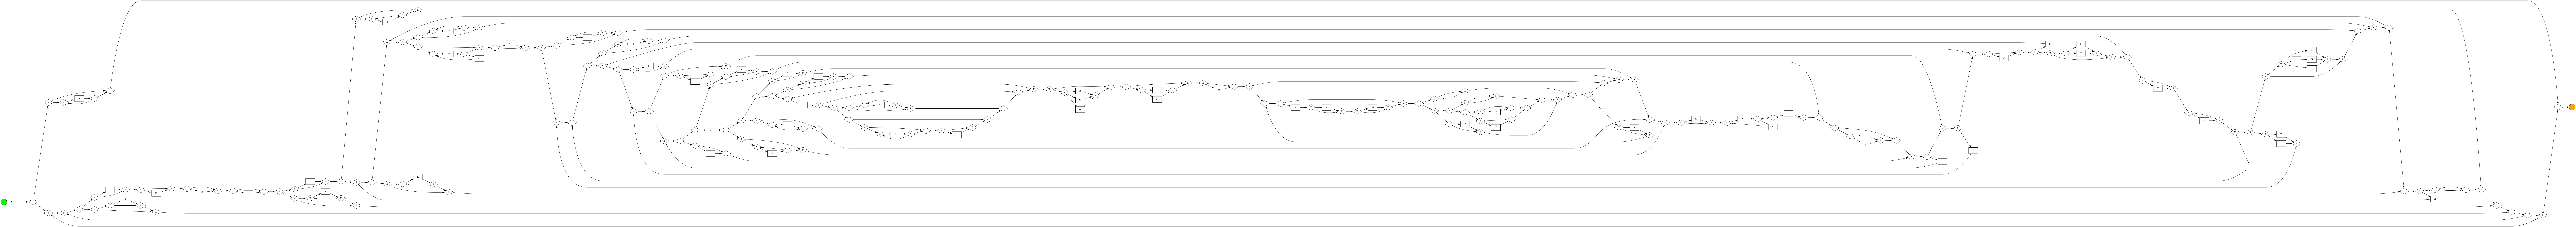

In [9]:
#Lendo Process trees e apresentando
trees =[]
for i in range(4):
    trees.append(pm4py.read_ptml("Trees/tree_"+str(i)+"_"+str(elemento)+".ptml"))
for i in range(len(trees)):
    #pm4py.view_process_tree(tree[i]) #Descomentar caso queira vizualizar as árvores 
    bpmn_graph = pm4py.convert_to_bpmn(trees[i])
    gviz = bpmn_visualization.apply(bpmn_graph)
    bpmn_visualization.view(gviz)

In [81]:
'''
# Salvando Process Trees do subs gerados
for i in range(len(subs)):
    tree = print_tree(subs[i], True)
    pm4py.write_ptml(tree, "Trees/tree_"+str(i)+".ptml")
'''
'''
#Lendo Process trees e apresentando
trees =[]
for i in range(4):
    trees.append(pm4py.read_ptml("Trees/tree_"+str(i)+".ptml"))
for i in range(len(trees)):
    print("____________________Process_Tree_"+str(i)+"____________________")
    pm4py.view_process_tree(trees[i])
'''

### Implementações posteriores e testes estruturais

In [12]:
ids = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12]
atv = ['a', 'b', 'c', 'd','a', 'b', 'c', 'd','a', 'b', 'c', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'b', 'c', 'e', 'f', 'b', 'c', 'd','a', 'b', 'c', 'e', 'f', 'b', 'c', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c', 'd','a', 'b', 'c', 'e', 'f', 'c', 'b', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c','e', 'f', 'c','d']
time = X['cadastro'][0:len(ids)]
df_teste = pd.DataFrame(zip(ids, atv, time), columns = ['caseId', 'atividade','cadastro'])
X = df_teste[['caseId', 'atividade','cadastro']]
groups = X.groupby(X.caseId)
traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))
log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
tree, sub = apply_tree(log, True)
MIN_TRACES = 6
#Executar até aqui para ter o problema
#subs é uma lista de todas as subtreeplain's geradas após a remoção do fall through
#subs = list_trees_IM_cluster(sub, 8)

strict_tau_loop 1 8 0
Retornando o novo sublog sem Fall-Through
Retornando o novo sublog sem Fall-Through


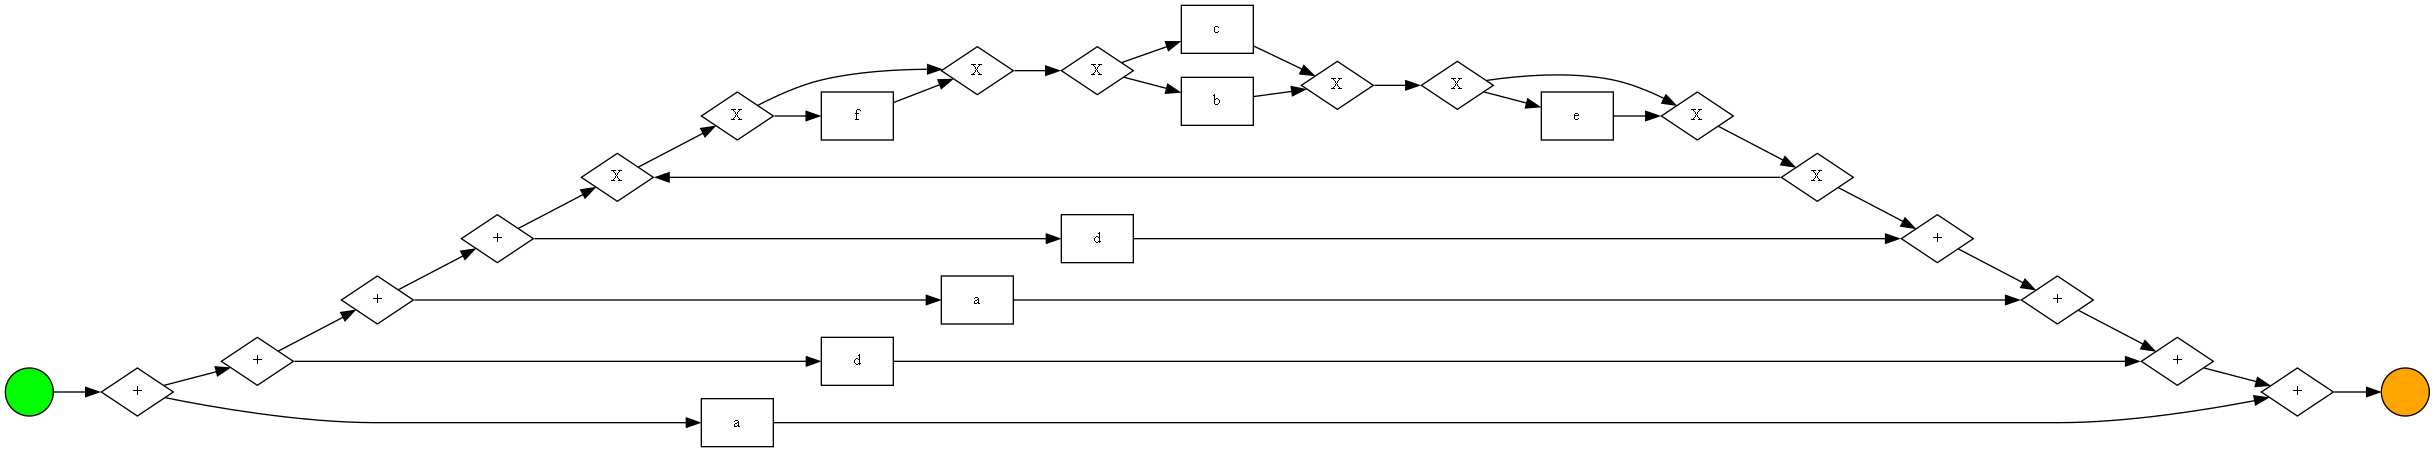

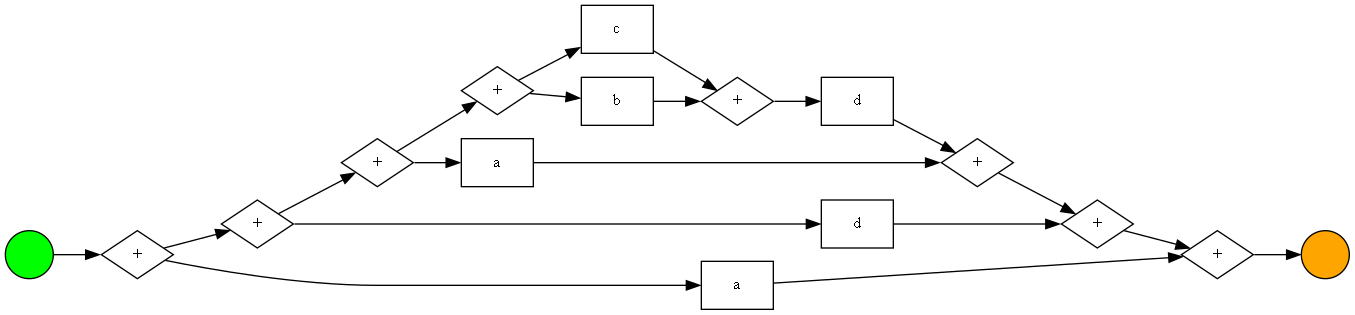

In [13]:
t = []
for i in range(len(tree)):
    #pm4py.view_process_tree(tree[i])
    bpmn_graph = pm4py.convert_to_bpmn(tree[i])
    gviz = bpmn_visualization.apply(bpmn_graph)
    bpmn_visualization.view(gviz)

In [7]:
def teste(s, sublog):    
    if s.log == sublog.log:
        print("SUBLOG encontrado")
        
        
    for t in range(len(s.children)):
        if(s.children[t]!=None):
            localizador(s.children[t], sublog)

def teste2(s, sublog):    
    for i in range(len(sublog.log)):
        for j in range(len(s.log._list)):
            if sublog.log[i] == s.log._list[j]:
                #s.log._list[j].remove(sublog.log._list[i])
                print("SUBLOG encontrado")
        
        
    for t in range(len(s.children)):
        if(s.children[t]!=None):
            localizador(s.children[t], sublog)

In [6]:
'''
ids = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,12]
atv = ['a', 'b', 'c', 'd','a', 'b', 'c', 'd','a', 'b', 'c', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'c', 'b', 'd','a', 'b', 'c', 'e', 'f', 'b', 'c', 'd','a', 'b', 'c', 'e', 'f', 'b', 'c', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c', 'd','a', 'b', 'c', 'e', 'f', 'c', 'b', 'd','a', 'c', 'b', 'e', 'f', 'b', 'c','e', 'f', 'c','d']
time = X['cadastro'][0:len(ids)]
df_teste = pd.DataFrame(zip(ids, atv, time), columns = ['caseId', 'atividade','cadastro'])
X = df_teste[['caseId', 'atividade','cadastro']]
groups = X.groupby(X.caseId)
traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))
log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
tree, sub = apply_tree(log, True)
#Executar até aqui para ter o problema
#subs é uma lista de todas as subtreeplain's geradas após a remoção do fall through
subs = list_trees_IM_cluster(sub, 8)
'''

'''
tree = print_tree(subs[0], True)
bpmn_graph = pm4py.convert_to_bpmn(tree)
gviz = bpmn_visualization.apply(bpmn_graph)
bpmn_visualization.view(gviz)
tree = print_tree(subs[1], True)
bpmn_graph = pm4py.convert_to_bpmn(tree)
gviz = bpmn_visualization.apply(bpmn_graph)
bpmn_visualization.view(gviz)
'''

'\ntree = print_tree(subs[0], True)\nbpmn_graph = pm4py.convert_to_bpmn(tree)\ngviz = bpmn_visualization.apply(bpmn_graph)\nbpmn_visualization.view(gviz)\ntree = print_tree(subs[1], True)\nbpmn_graph = pm4py.convert_to_bpmn(tree)\ngviz = bpmn_visualization.apply(bpmn_graph)\nbpmn_visualization.view(gviz)\n'

In [24]:
'''
MIN_TRACES_LIST = [32,64,128,256]
total_traces = [2000,5000,10000]
mostrar = False
for i in MIN_TRACES_LIST:
    print("Modelo com MIN_TRACES = "+str(i))
    for j in (total_traces):
        print("Modelo com total de traces "+str(j))
        X = df[['caseId', 'atividade','cadastro']]
        X = X[0:j]
        groups = X.groupby(X.caseId)
        traces = X.groupby(X.caseId)['atividade'].agg(str=lambda x: '-'.join(x))


        log = pm4py.format_dataframe(X, case_id='caseId', activity_key='atividade', timestamp_key='cadastro')
        sub = apply_tree(log, False)
        subs = list_trees_IM_cluster(sub,i)
        
        if mostrar:
            for k in range(len(subs)):
                print("____________________BPM_"+str(k)+"____________________")
                tree = print_tree(subs[k], True)
                bpmn_graph = pm4py.convert_to_bpmn(tree)
                gviz = bpmn_visualization.apply(bpmn_graph)
                bpmn_visualization.view(gviz)
    print("______________________________________________________________________________________________________________________")
    '''

'\nMIN_TRACES_LIST = [32,64,128,256]\ntotal_traces = [2000,5000,10000]\nmostrar = False\nfor i in MIN_TRACES_LIST:\n    print("Modelo com MIN_TRACES = "+str(i))\n    for j in (total_traces):\n        print("Modelo com total de traces "+str(j))\n        X = df[[\'caseId\', \'atividade\',\'cadastro\']]\n        X = X[0:j]\n        groups = X.groupby(X.caseId)\n        traces = X.groupby(X.caseId)[\'atividade\'].agg(str=lambda x: \'-\'.join(x))\n\n\n        log = pm4py.format_dataframe(X, case_id=\'caseId\', activity_key=\'atividade\', timestamp_key=\'cadastro\')\n        sub = apply_tree(log, False)\n        subs = list_trees_IM_cluster(sub,i)\n        \n        if mostrar:\n            for k in range(len(subs)):\n                print("____________________BPM_"+str(k)+"____________________")\n                tree = print_tree(subs[k], True)\n                bpmn_graph = pm4py.convert_to_bpmn(tree)\n                gviz = bpmn_visualization.apply(bpmn_graph)\n                bpmn_visuali